### Create multifaceted plots to display human diversity in the Arivale and the Human Gut cohort

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import matplotlib
import warnings
warnings.simplefilter('ignore')
from arivale_data_interface import *
frozen_ss_path='/proj/arivale/snapshots/arivale_snapshot_ISB_2020-03-16_2156'
sn=list_snapshot_contents() #list all content
def get_frozen_snapshot(ss_name, ss_path=frozen_ss_path): #collect data
    return get_snapshot(ss_name, path=ss_path)
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf

In [2]:
genpath = '/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome'

In [3]:
# Get amgut metadata, filter, and merge with amgut data
metadata = pd.read_csv(genpath+'/american_gut_cohort/american_gut/metadata.tsv', sep = '\t', low_memory = False)[['sample_name','sex','height_cm', 'age_years', 'weight_kg', 'bowel_movement_frequency']]

amgut=pd.read_csv(genpath+'/american_gut_cohort/alpha-diversity.csv')
amgut=amgut.rename(columns = {'Unnamed: 0':'sample_name'})
amgut=pd.merge(metadata, amgut, on ='sample_name')

#Converting values to numeric
amgut['height_cm'] = pd.to_numeric(amgut['height_cm'], errors = 'coerce')
amgut['weight_kg'] = pd.to_numeric(amgut['weight_kg'], errors='coerce')
amgut['age_years'] =  pd.to_numeric(amgut['age_years'], errors='coerce')

#Filter
amgut=amgut[amgut['age_years'] >= 18].rename(columns = {'age_years':'age'})
amgut=amgut[(amgut['height_cm'] <= 244) & (amgut['height_cm'] >= 122)]
amgut=amgut[amgut['weight_kg']<300]

# # Convert BMF to numeric for regressions
norm_bmf=list()
for i in range(0,len(amgut)):
    check = amgut.iloc[i,5]
    if check == 'Less than one':
        norm_bmf.append(1)
    elif check == 'One':
        norm_bmf.append(2)
    elif check == 'Two':
        norm_bmf.append(3)
    elif check == 'Three':
        norm_bmf.append(4)
    elif check == 'Four':
        norm_bmf.append(5)
    elif check=='Five or more':
        norm_bmf.append(6)
    else:
        norm_bmf.append(float('nan'))
        
amgut['bowel_movement_frequency']=norm_bmf

# Convert height from cm to inches so I can calculate the BMI 
amgut['height_in']=amgut['height_cm'].apply(lambda x: x/2.54)
amgut['weight_lb']=amgut['weight_kg'].apply(lambda x: x*2.205)
amgut['BMI_CALC']= amgut['weight_lb']/(amgut['height_in']**2)*703

# Convert sex info to binomial M and F
sexes=['female', 'male']
amgut=amgut[amgut['sex'].isin(sexes)]
amgut['sex']=amgut['sex'].apply(lambda x: 'F' if x=='female' else 'M')

amgut.head()

,sample_name,sex,height_cm,age,weight_kg,bowel_movement_frequency,Unnamed: 0.1,simpson,inv_simpson,height_in,weight_lb,BMI_CALC
0,10317.000001000,F,154.0,64.0,52.0,3.0,4350,0.845933,6.490674,60.629921,114.66,21.927709
1,10317.000001001,M,175.0,53.0,110.0,NaN,3832,0.848227,6.588768,68.897638,242.55,35.920960
2,10317.000001002,F,168.0,53.0,56.0,NaN,1616,0.891895,9.250269,66.141732,123.48,19.842702
3,10317.000001004,F,157.0,44.0,86.0,NaN,3409,0.934298,15.220144,61.811024,189.63,34.892372
4,10317.000001008,F,157.0,66.0,74.0,NaN,2322,0.797388,4.935530,61.811024,163.17,30.023669


In [4]:
arivale=pd.read_csv(genpath+'/arivale_cohort/alpha-diversity.csv').rename(columns={'Unnamed: 0':'id'})

# Get sample metadata and merge
metadata = pd.read_csv('/proj/arivale/microbiome/16S_processed/metadata.csv')[['public_client_id', 'id', 'days_in_program','sex', 'age']]\
                        .rename(columns = {'public_client_id':'sample_id'})


arivale = pd.merge(arivale, metadata, on = 'id')

# Get weight data and merge
weights = get_frozen_snapshot('weight')[['public_client_id', 'days_in_program', 'BMI_CALC', 'HEIGHT_CALC']]\
                     .dropna().rename(columns = {'public_client_id':'sample_id'})

arivale = pd.merge_asof(
    arivale[arivale.sample_id.isin(weights.sample_id)].sort_values(by='days_in_program'),
    weights.sort_values(by='days_in_program'), 
    by = 'sample_id', on = 'days_in_program', direction='nearest')

# convert height from in to cm 
arivale['height_cm']=arivale['HEIGHT_CALC'].apply(lambda x: x*2.54)

# Finally, I need bowel movement frequency 
digestion = get_frozen_snapshot('assessments_digestive_health')[['public_client_id', 'days_in_program', 'assessment:digestion:bowel-movements:enum']].dropna().rename(columns = {'public_client_id':'sample_id'})

# Get the bowel movement number 
digestion['bowel_movement_frequency'] = digestion['assessment:digestion:bowel-movements:enum'].astype(str).apply(lambda x: x[1])
digestion['bowel_movement_frequency'] = digestion['bowel_movement_frequency'].astype(int)

arivale = pd.merge_asof(
    arivale[arivale.sample_id.isin(arivale.sample_id)].sort_values(by='days_in_program'),
    digestion.sort_values(by='days_in_program'),
    by='sample_id', on='days_in_program', direction='nearest')

arivale.head()

/users/kramos/miniconda3/envs/micom/lib/python3.8/site-packages/arivale_data_interface/snapshots_interface.py:271: DeprecationWarning: `assessments_digestive_health` is slated for deprecation and will be part of `assessments` with raw data will be available in `assessments_raw`
  check_deprecation(name) # check if requested snapshot is to be deprecated


,Unnamed: 0.1,id,simpson,inv_simpson,sample_id,days_in_program,sex,age,BMI_CALC,HEIGHT_CALC,height_cm,assessment:digestion:bowel-movements:enum,bowel_movement_frequency
0,5216,AV15-4372|AKE035,0.973573,37.839776,01602320,-2.0,M,47.0,37.229730,74.0,187.96,(3) 1-3 times daily,3.0
1,5081,AV15-3716|AKE025,0.977155,43.774041,01228476,0.0,F,50.0,22.462722,65.0,165.10,(3) 1-3 times daily,3.0
2,4993,AV15-3588|AKE025,0.910552,11.179723,01949838,1.0,F,31.0,25.328546,63.0,160.02,(2) 3-6 times per week,2.0
3,4831,AV15-2608|AKE034,0.980011,50.027191,01788725,1.0,M,32.0,27.006658,69.0,175.26,(2) 3-6 times per week,2.0
4,4037,AV15-1295|AKE009,0.979111,47.871679,01421882,1.0,F,19.0,23.793846,65.0,165.10,NaN,NaN


### Transform and standardize data

In [5]:
# Drop duplicate data
arivale=arivale.sort_values(by='days_in_program').drop_duplicates(subset='sample_id', keep='first')
amgut=amgut.drop_duplicates(subset='sample_name', keep='first')

In [6]:
# Log transform Simpson's Diversity and height
features = ['inv_simpson', 'height_cm']
arivale[features] = arivale[features].apply(lambda x: np.log(x))
amgut[features] = amgut[features].apply(lambda x: np.log(x))


In [7]:
amgut[['sex', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']].describe()

,age,BMI_CALC,bowel_movement_frequency,height_cm,inv_simpson
count,7952.000000,7952.000000,5572.000000,7952.000000,7952.000000
mean,48.496353,24.391668,2.472362,5.141359,2.650101
std,14.801270,5.511185,0.948195,0.059693,0.672342
min,18.000000,0.000000,1.000000,4.844187,0.040350
25%,37.000000,21.108790,2.000000,5.105945,2.250919
50%,49.000000,23.439192,2.000000,5.135798,2.727923
75%,60.000000,26.317689,3.000000,5.181784,3.131715
max,95.000000,107.629441,6.000000,5.384495,4.388151


In [8]:
arivale[['sex', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']].describe()

,age,BMI_CALC,bowel_movement_frequency,height_cm,inv_simpson
count,3634.000000,3634.000000,3067.000000,3634.000000,3634.000000
mean,48.284810,27.520964,2.672318,5.140097,3.581565
std,12.473282,6.225105,0.553020,0.056850,0.511123
min,18.000000,13.627490,1.000000,4.921148,1.190037
25%,39.000000,23.290590,2.000000,5.091047,3.288488
50%,48.000000,26.115807,3.000000,5.136857,3.642711
75%,57.000000,30.357324,3.000000,5.180659,3.937297
max,87.000000,63.606396,4.000000,5.314191,4.980869


In [9]:
amgut=amgut[['age', 'sex', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']].dropna()
arivale=arivale[['age', 'sex', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']].dropna()

## OLS regressions in more detail (used to generate Table 1)

In [10]:
# Normalize prior to running regressions because BMF is not on the same scale in each cohort
features=['age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']
amgut[features]=amgut[features].apply(lambda x: (x - x.mean()) / x.std())
arivale[features]=arivale[features].apply(lambda x: (x-x.mean()) / x.std())

#### Generate a dict that has formulas and its covariates ####
covars = ['C(sex)', 'age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm']
d_formula=dict()
d_formula[0] = {
    'formula':'inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + height_cm',
    'excluded':'none',
    'covariates':list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]'), covars))}

d_formula[1] = {
    'formula':'inv_simpson ~ height_cm',
    'excluded':'all but height',
    'covariates':float('NaN')}

for i in range(0,len(covars)):
    excluded=covars[i]
    temp_covars=[i for i in covars if i != excluded]
    formula=' + '.join(temp_covars)
    formula = 'inv_simpson ~ '+formula
    temp_covars=list(map(lambda x: x.replace('C(sex)', 'C(sex)[T.M]'),temp_covars))
    
    d_formula[i+2] = {
        'formula':formula,
        'excluded':excluded,
        'covariates':temp_covars}

d_formula

{0: {'formula': 'inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency + height_cm',
  'excluded': 'none',
  'covariates': ['C(sex)[T.M]',
   'age',
   'BMI_CALC',
   'bowel_movement_frequency',
   'height_cm']},
 1: {'formula': 'inv_simpson ~ height_cm',
  'excluded': 'all but height',
  'covariates': nan},
 2: {'formula': 'inv_simpson ~ age + BMI_CALC + bowel_movement_frequency + height_cm',
  'excluded': 'C(sex)',
  'covariates': ['age', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm']},
 3: {'formula': 'inv_simpson ~ C(sex) + BMI_CALC + bowel_movement_frequency + height_cm',
  'excluded': 'age',
  'covariates': ['C(sex)[T.M]',
   'BMI_CALC',
   'bowel_movement_frequency',
   'height_cm']},
 4: {'formula': 'inv_simpson ~ C(sex) + age + bowel_movement_frequency + height_cm',
  'excluded': 'BMI_CALC',
  'covariates': ['C(sex)[T.M]',
   'age',
   'bowel_movement_frequency',
   'height_cm']},
 5: {'formula': 'inv_simpson ~ C(sex) + age + BMI_CALC + height_cm',
  'excluded

### Getting the $r^2$ of each individual covariate in my model

In [11]:
def find_covar_rsq(dataframe, f_dict):
    big_squared=pd.DataFrame()
    
    for i in range(0, len(f_dict)): # for every formula combination in my dictionary 
        if i==0: # first entry in the dict is the full formula 
            results = smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit() 
            ref_r=results.rsquared # this is going to be used to derive r_squared of indiviudal covariates
            betas=pd.DataFrame(results.params).reset_index().rename(columns={'index':'covar', 0:'Beta'}) # get beta coefficients
            betas['formula']=f_dict[i]['formula'] # record the formula used
            betas['rsquared_model']=results.rsquared # get the rsquared of the model 
            ps = pd.DataFrame(results.pvalues.loc[f_dict[i]['covariates']]).reset_index().rename(columns={0:'p_covar', 'index':'covar'}) # get pvalues for each covar
            betas=pd.merge(betas, ps, on = 'covar') #merge ps with beta coefficients for each covar
            
            ### F-test to compare model with and without height as a covar
            model_reduced = smf.ols(formula = 'inv_simpson ~ age + C(sex) + BMI_CALC + bowel_movement_frequency', data=dataframe).fit()
            F_test = anova_lm(model_reduced, results)
            betas['F']=F_test.loc[1,'F']
            betas['F_pval']=F_test.loc[1,'Pr(>F)']

        
        elif i==1: # the second entry in my dict is just simpson vs height
            # like before, get beta coefficient and r^2 values
            results=smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit()
            temp=pd.DataFrame(results.params).reset_index().rename(columns={'index':'covar', 0:'Beta'})
            temp['formula']=f_dict[i]['formula']
            temp['rsquared_model']=results.rsquared
            temp['p_covar']=results.pvalues['height_cm']
            
            F_test = anova_lm(results)
            temp['F']=F_test.loc['height_cm','F']
            temp['F_pval']=F_test.loc['height_cm','PR(>F)']
            betas=pd.concat([betas, temp])
        
        else: # for every other formula, we excluded one covar so we can derive the r^2 for indiviudal covars
            results = smf.ols(formula=f_dict[i]['formula'], data=dataframe).fit() #ols with the formula[i]
            squared_df=pd.DataFrame(columns=['covar', 'rsquared_covar', 'formula', 'rsquared_model'])
            squared_df.loc[i,'covar']=f_dict[i]['excluded'] # the excluded covar is the one we are getting an r^2 value for
            squared_df.loc[i,'rsquared_covar']=ref_r-results.rsquared
            squared_df.loc[i,'formula']=f_dict[i]['formula']
            squared_df.loc[i,'rsquared_model']=ref_r
            big_squared=pd.concat([big_squared, squared_df])
    
    #Now we have everything we need to make one big df with my regression info 
    big_squared.loc[2,'covar']='C(sex)[T.M]' #so I can merge my dfs on covars
    complete=pd.merge(big_squared[['covar', 'rsquared_covar', 'rsquared_model']], \
                      betas[['covar', 'Beta', 'formula', 'rsquared_model', 'p_covar', 'F', 'F_pval']], \
                      on=['covar', 'rsquared_model'], how='right')
    return(complete, F_test)

arivale_results, arivale_F= find_covar_rsq(arivale, d_formula)
amgut_results, amgut_F = find_covar_rsq(amgut, d_formula)

In [12]:
arivale_results['cohort']='Arivale' # add cohort info so I can merge results
amgut_results['cohort']='American Gut'

complete=pd.concat([arivale_results, amgut_results])
complete=complete[complete['covar']!='Intercept'] # I don't want the intercept
complete=complete[['cohort','covar', 'rsquared_covar', 'p_covar', 'Beta', 'formula', 'rsquared_model', 'F', 'F_pval']]


In [13]:
complete

,cohort,covar,rsquared_covar,p_covar,Beta,formula,rsquared_model,F,F_pval
0,Arivale,C(sex)[T.M],0.001733,1.750740e-02,-0.121864,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
1,Arivale,age,0.00596,1.078319e-05,0.077571,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
2,Arivale,BMI_CALC,0.033916,1.977540e-25,-0.184949,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
3,Arivale,bowel_movement_frequency,0.009105,5.488775e-08,-0.097543,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
4,Arivale,height_cm,0.009564,2.556615e-08,0.138440,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
6,Arivale,height_cm,NaN,1.261889e-06,0.087366,inv_simpson ~ height_cm,0.007633,23.574488,1.261889e-06
0,American Gut,C(sex)[T.M],0.001497,3.582354e-03,-0.107685,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05
1,American Gut,age,0.008405,5.557170e-12,0.092832,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05
2,American Gut,BMI_CALC,0.000937,2.115062e-02,-0.031406,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05
3,American Gut,bowel_movement_frequency,0.007282,1.400467e-10,-0.085957,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05


In [14]:
# Save to csv so I can make an excel table with it
complete.to_csv(genpath+'/output/regression_results.csv')

In [15]:
complete=complete.reset_index()
complete

,index,cohort,covar,rsquared_covar,p_covar,Beta,formula,rsquared_model,F,F_pval
0,0,Arivale,C(sex)[T.M],0.001733,1.750740e-02,-0.121864,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
1,1,Arivale,age,0.00596,1.078319e-05,0.077571,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
2,2,Arivale,BMI_CALC,0.033916,1.977540e-25,-0.184949,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
3,3,Arivale,bowel_movement_frequency,0.009105,5.488775e-08,-0.097543,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
4,4,Arivale,height_cm,0.009564,2.556615e-08,0.138440,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.061118,31.180689,2.556615e-08
5,6,Arivale,height_cm,NaN,1.261889e-06,0.087366,inv_simpson ~ height_cm,0.007633,23.574488,1.261889e-06
6,0,American Gut,C(sex)[T.M],0.001497,3.582354e-03,-0.107685,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05
7,1,American Gut,age,0.008405,5.557170e-12,0.092832,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05
8,2,American Gut,BMI_CALC,0.000937,2.115062e-02,-0.031406,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05
9,3,American Gut,bowel_movement_frequency,0.007282,1.400467e-10,-0.085957,inv_simpson ~ age + C(sex) + BMI_CALC + bowel_...,0.019016,17.481901,2.945089e-05


In [16]:
arivale_height_rsq = complete.loc[4, 'rsquared_covar']
amgut_height_rsq = complete.loc[10, 'rsquared_covar']

arivale_height_p = complete.loc[4, 'p_covar']
amgut_height_p = complete.loc[10, 'p_covar']

In [17]:
amgut=amgut[['age', 'sex', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']].dropna()
arivale=arivale[['age', 'sex', 'BMI_CALC', 'bowel_movement_frequency', 'height_cm', 'inv_simpson']].dropna()

# Add color column so I can assign them when I plot
amgut['color'] = amgut.sex.apply(lambda x: '#AA4499' if x == 'F' else '#88CCEE')
arivale['color'] = arivale.sex.apply(lambda x: '#AA4499' if x == 'F' else '#88CCEE')

# Order values by sex so that color assignment is correct
amgut = amgut.sort_values(by='sex', ascending=False)
arivale = arivale.sort_values(by='sex', ascending=False)

### Plot

Text(0.0, 1.0, 'b')

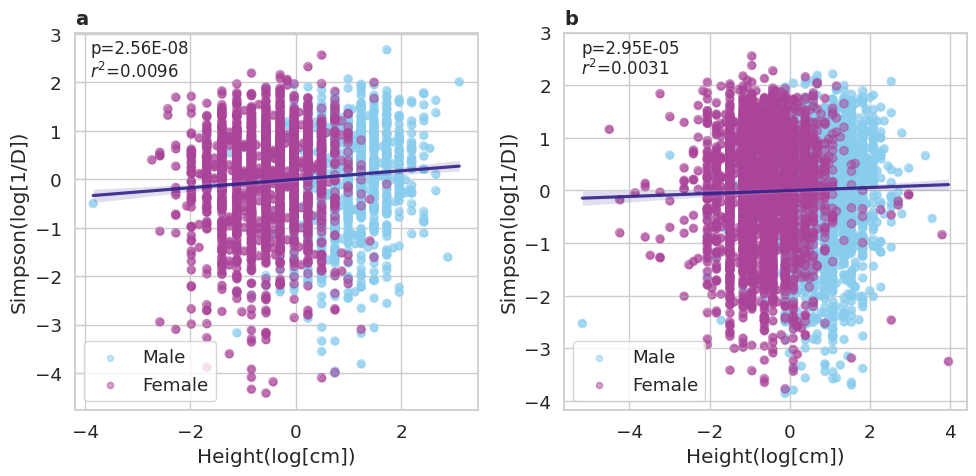

In [18]:
sns.set_theme(style='whitegrid',font_scale=1.2)
fig, axs = plt.subplots(1,2, figsize=(10,5), tight_layout=True)


x = 'height_cm'
y = 'inv_simpson'

color_label = {'#88CCEE':'Male', '#AA4499':'Female'}
colors = ['#88CCEE','#AA4499']
labels = [color_label[x] for x in arivale['color'].unique()]

sns.regplot(data = arivale, ax = axs[0],
            x=x, y=y,scatter_kws={'c':arivale['color'], 'color':None, 'alpha':0.5, 'zorder':1},\
            line_kws={'color':'#332288', 'alpha':0.9})

index =0
for i, grp in arivale.groupby(['color']):
    grp.plot(kind = 'scatter', x=x, y=y, c=i, ax = axs[0], zorder=0, alpha = 0.5, label=labels[index])
    index +=1

labels = [color_label[x] for x in amgut['color'].unique()]

sns.regplot(data = amgut, ax = axs[1],
            x=x, y=y,scatter_kws={'c':amgut['color'], 'color':None, 'alpha':0.5, 'zorder':1},\
            line_kws={'color':'#332288', 'alpha':0.9})

index =0
for i, grp in amgut.groupby(['color']):
    grp.plot(kind = 'scatter', x=x, y=y, c=i, ax = axs[1], zorder=0, alpha = 0.5, label = labels[index])
    index +=1

axs[0].set(xlabel='Height(log[cm])',ylabel='Simpson(log[1/D])')
axs[0].text(-3.9,2.6, f'p={arivale_height_p:.2E}', fontsize=12)
axs[0].text(-3.9,2.1,f'$r^2$={arivale_height_rsq:.4f}', fontsize=12)
axs[0].set_title('a', loc='left', fontsize=14, fontweight='bold')

axs[1].set(xlabel='Height(log[cm])', ylabel='Simpson(log[1/D])')
axs[1].set_yticks([-4, -3, -2, -1, 0, 1, 2, 3])
axs[1].text(-5.2,2.6, f'p={amgut_height_p:.2E}', fontsize=12)
axs[1].text(-5.2,2.2,f'$r^2$={amgut_height_rsq:.4f}', fontsize=12)
axs[1].set_title('b', loc='left', fontsize=14, fontweight='bold')


In [19]:
fig.savefig(genpath+'/output/all_human_cohort_diversity.pdf')